**Assignment 1 Task 3: Ridge Regression**  
**Student ID = 31237223**  
**Name = Yee Darren Jer Shien**

**Question 6.1 Derivation of Weight Update Steps**

1) Ridge Regression Function as described in lectures  

    $E(w) =\frac{1}{2} \sum_{n=1}^{N} (t_n -(w^T \phi(x_n)))^2 + {\frac{\lambda}{2}}w^2$    
    
  
2) Derivation of the above function to obtain gradient (derive function wrt W). The first part is similar to Activity 2.1 SGD, with the second term being the ridge regression term.  

    $\nabla E(w) = \frac{1}{\text{batch_size}} (\phi(x_n)^T(\phi(x_n) w_{n-1} - t_n)) + 2\lambda w_{n-1}$    
    
3) SGD weight update rule (basic SGD)  

    $w_{n} = w_{n-1} - \eta \nabla E(w_{n-1})$  
    
4) Putting it all together, we can get the following formula for weight update using SGD   

    $w_n = w_{n-1} - \eta \left[\frac{1}{\text{batch_size}} (\phi(x_n)^T(\phi(x_n) w_{n-1} - t_n)) + 2\lambda w_{n-1} \right]$


**Question 6.2 SGD with derrived weight update**

In [133]:
# SGD Class Adpated from Activity 2.1 of Module 2
class SGDRidgeRegressor:

    def __init__(self, batch_size=1, eta=0.001, tau_max=5000, epsilon=0.0001, random_state=None, lam = 0.1):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        self.lam = lam
        
    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))
        for tau in range(1, self.tau_max+1):
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            grad = ((1 / self.batch_size) * (x[idx].T.dot(x[idx].dot(self.w_[tau-1])-y[idx].flatten()))) + (2 * self.lam * self.w_[tau - 1])
            self.w_[tau] = self.w_[tau - 1] - self.eta * grad

        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)


**Question 6.3 L2 Regularisaton training and testing errors**

In [137]:
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return np.sin(5*np.pi*x)/(1+2*x)

def make_additive_noise_data(n, f, a, b, noise=0.1**0.5, random_state=None):
    RNG = np.random.default_rng(random_state)
    x = RNG.uniform(a, b, size=(n, 1))
    y = f(x) + RNG.normal(0, noise, size=(n, 1))
    return x, y

In [138]:
def plot_function(f, a, b, models=[], data=None, ax=None, ax_labels=True, legend=True):
    ax = plt.gca() if ax is None else ax
    xx = np.linspace(a, b, 200).reshape(-1, 1)
    if len(models)==1:
        ax.fill_between(xx.squeeze(), f(xx).squeeze(), models[0].predict(xx).squeeze(), alpha=0.3)
        ax.plot(xx, models[0].predict(xx), label='$y$')
    if len(models) > 1:
        for model in models: ax.plot(xx, model.predict(xx), color='gray', alpha=0.5)
    ax.plot(xx, f(xx), color='black', label='$f$')
    if data is not None:
        x, y = data
        ax.scatter(x, y, marker='.', color='black', label='data')
    if ax_labels:
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')
    if legend: ax.legend()
    ax.margins(x=0)

In [139]:
class PolynomialFeatures:

    def __init__(self, degree):
        self.degree = degree

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        output = []
        for i in range(0, self.degree+1):
            column = x**i
            output.append(column)
        return np.column_stack(output)

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x, y)

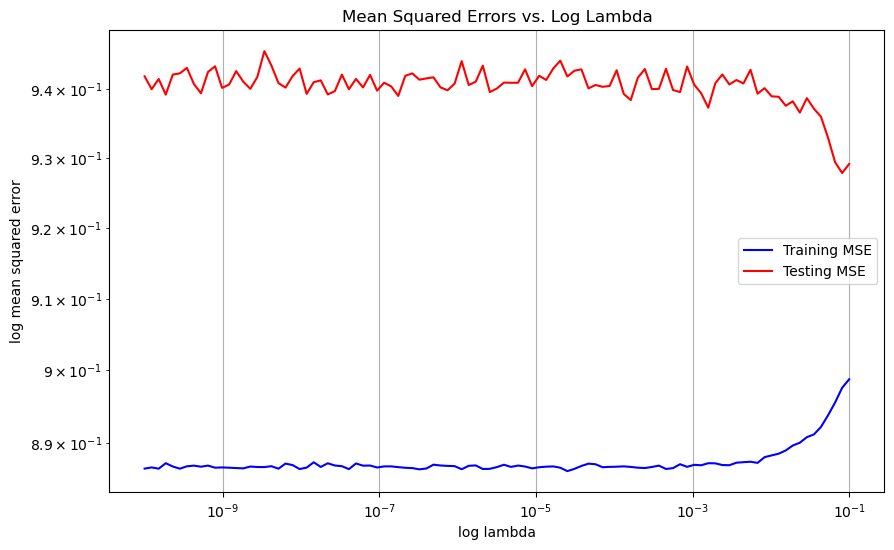

In [140]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from numpy import random

poly = PolynomialFeatures(5)
lambda_choices = np.geomspace(10**-10,0.1, 101, endpoint=True)
models = []
reps = 10
train_mse = [[] for i in range (len(lambda_choices))]
test_mse = [[] for i in range (len(lambda_choices))]

for rep in range (10):
    x_train, y_train = make_additive_noise_data(20, f, -0.3, 0.3, random_state=rep)
    x_test, y_test = make_additive_noise_data(300, f, -0.3, 0.3, random_state=rep)
    
    for i in range (len(lambda_choices)):
        
        transformation_then_ridge = make_pipeline(poly, SGDRidgeRegressor(lam = lambda_choices[i],batch_size = 5))
        transformation_then_ridge.fit(x_train, y_train)
        
        y_train_pred = transformation_then_ridge.predict(x_train)
        y_test_pred = transformation_then_ridge.predict(x_test)
        
        train_mse[i].append(mean_squared_error(y_train, y_train_pred))
        test_mse[i].append(mean_squared_error(y_test, y_test_pred))

train_mse_mean = np.array([np.mean(mse) for mse in train_mse])
test_mse_mean = np.array([np.mean(mse) for mse in test_mse])    

# Plot the mean squared errors on log-log scale plot
plt.figure(figsize=(10, 6))
plt.plot(lambda_choices, train_mse_mean, label='Training MSE', color='blue')
plt.plot(lambda_choices, test_mse_mean, label='Testing MSE', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log lambda')
plt.ylabel('log mean squared error')
plt.title('Mean Squared Errors vs. Log Lambda')
plt.legend()
plt.grid(True)
plt.show()


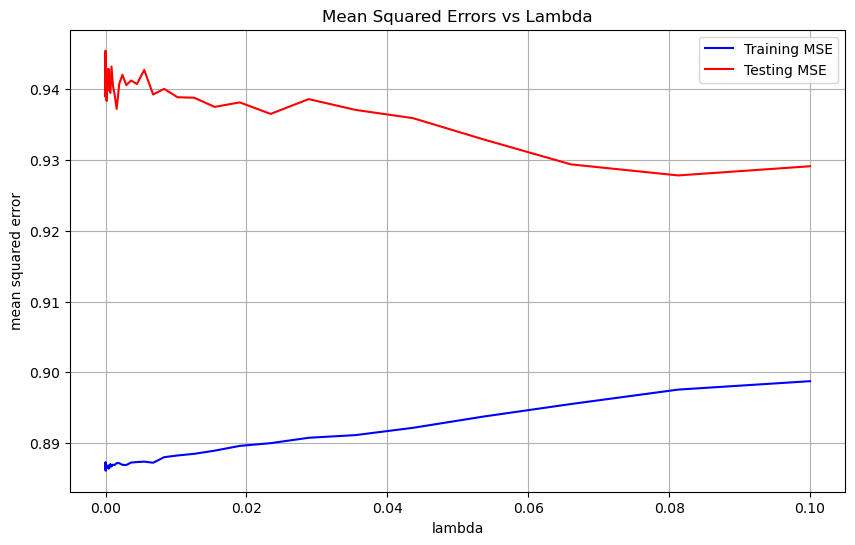

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_choices, train_mse_mean, label='Training MSE', color='blue')
plt.plot(lambda_choices, test_mse_mean, label='Testing MSE', color='red')
plt.xlabel('lambda')
plt.ylabel('mean squared error')
plt.title('Mean Squared Errors vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

**Question 6.3C Justification**

As we can see from the graphs, **MSE increases during the initial stages of lambda, which shows signs of overfitting due to the fact that test error is still incredibly high as well, with train error falling slightly**. However, as we slowly increase the lambda, we can see that the **test mse falls dramatically which indicates that the model becomes less complex, thus allowing the model to learn less noise and reduce overfitting with the data and in turn allow a reduction in testing error**. However, once the lambda is increased closer to 0.1, we can see the **testing MSE and training MSE starts to increase which seems to suggest the model is too simple due to the large punishments made by the Ridge Regression** term thus causing **underfitting to happen and the model not being able to capture enough patterns to perform well on both seen and unseen data**. 
